# Amazon Reviews 2023 Data Loading and Preprocessing

This notebook loads and preprocesses the Amazon Books dataset for Semantic ID generation in the recommendation system.

## Overview
- Load Amazon Books reviews and metadata
- Clean and filter the data
- Prepare item descriptions for Semantic ID generation
- Create user-item interaction matrix
- Save processed datasets for next phase

### 1. Import Libraries and Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')
from preprocessing import stream_jsonl_gz, get_item_id, unix_seconds, scrub, to_text_list, join_short, build_description, shape_history, show_examples, eval_tail
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoTokenizer

REVIEWS_PATH = "data/raw/Books_reviews.jsonl.gz"
META_PATH    = "data/raw/Books_meta.jsonl.gz"

OUT_ROOT = "data/processed/books"
os.makedirs(OUT_ROOT, exist_ok=True)

ITEMS_OUT = f"{OUT_ROOT}/items.parquet"
INTER_OUT = f"{OUT_ROOT}/interactions.parquet"

### 2. Load and Inspect Raw Data

In [3]:
# Reviews preview
r_samp = []
for i, obj in enumerate(stream_jsonl_gz(REVIEWS_PATH)):
    r_samp.append(obj)
    if i >= 4: break

print("REVIEWS (5 rows) keys:")
for j, o in enumerate(r_samp, 1):
    print(f"\nRow {j}:")
    for k, v in o.items():
        if isinstance(v, str) and len(v) > 100:
            print(f"  {k}: {v[:100]}...")
        else:
            print(f"  {k}: {v}")

# Metadata preview
m_samp = []
for i, obj in enumerate(stream_jsonl_gz(META_PATH)):
    m_samp.append(obj)
    if i >= 4: break

print("\n\nMETA (5 rows) keys:")
for j, o in enumerate(m_samp, 1):
    print(f"\nRow {j}:")
    for k, v in o.items():
        if isinstance(v, str) and len(v) > 100:
            print(f"  {k}: {v[:100]}...")
        else:
            print(f"  {k}: {v}")


REVIEWS (5 rows) keys:

Row 1:
  rating: 1.0
  title: Not a watercolor book! Seems like copies imo.
  text: It is definitely not a watercolor book.  The paper bucked completely.  The pages honestly appear to ...
  images: [{'small_image_url': 'https://m.media-amazon.com/images/I/516HBU7LQoL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/516HBU7LQoL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/516HBU7LQoL._SL1600_.jpg', 'attachment_type': 'IMAGE'}, {'small_image_url': 'https://m.media-amazon.com/images/I/71+XwcacMmL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/71+XwcacMmL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/71+XwcacMmL._SL1600_.jpg', 'attachment_type': 'IMAGE'}, {'small_image_url': 'https://m.media-amazon.com/images/I/71RbTuvD1ZL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/71RbTuvD1ZL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I

### 3. Check Coverage and Select Join Key

In [3]:
MAX_SCAN = None  # None for full scan

# collect IDs from meta (parent_asin only)
meta_parent = set()
for i, obj in enumerate(stream_jsonl_gz(META_PATH)):
    if obj.get("parent_asin"):
        meta_parent.add(str(obj["parent_asin"]))
    if MAX_SCAN and i+1 >= MAX_SCAN: break

# collect IDs from reviews (both fields)
rev_parent, rev_asin = set(), set()
for i, obj in enumerate(stream_jsonl_gz(REVIEWS_PATH)):
    if obj.get("parent_asin"):
        rev_parent.add(str(obj["parent_asin"]))
    if obj.get("asin"):
        rev_asin.add(str(obj["asin"]))
    if MAX_SCAN and i+1 >= MAX_SCAN: break

print(f"Meta parent_asin unique: {len(meta_parent):,}")
print(f"Reviews parent_asin unique: {len(rev_parent):,} | asin unique: {len(rev_asin):,}")

cov_parent = len(rev_parent & meta_parent) / max(len(rev_parent), 1)
cov_asin   = len(rev_asin & meta_parent) / max(len(rev_asin), 1)
print(f"Coverage if we use reviews parent_asin → meta parent_asin: {cov_parent:.3f}")
print(f"Coverage if we use reviews asin       → meta parent_asin: {cov_asin:.3f}")

Meta parent_asin unique: 4,448,181
Reviews parent_asin unique: 4,446,065 | asin unique: 4,493,336
Coverage if we use reviews parent_asin → meta parent_asin: 1.000
Coverage if we use reviews asin       → meta parent_asin: 0.985


### 4. Build Item Descriptions

In [4]:
# Try it on 5 metadata samples to see the effect
for i, obj in enumerate(stream_jsonl_gz(META_PATH)):
    item_id = get_item_id(obj)
    if not item_id: 
        continue
    built = build_description(obj)
    print(f"\nITEM {item_id} | len={len(built)}")
    print(built[:300], "..." if len(built) > 300 else "")
    if i >= 4: break



ITEM 0701169850 | len=101
Chaucer: Hardcover – Import, January 1, 2004 Literature & Fiction > History & Criticism Peter Ackroyd 

ITEM 0435088688 | len=403
Contains 23 selected articles by this influential writer, researcher, educator, and speaker. They're grouped around six major themes inherent in teacher education: culture and community; miscue analysis, reading strategies and comprehension; print awareness and the roots of literacy; the writing pro ...

ITEM 0316185361 | len=604
Marcus Luttrell, author of the #1 bestseller • Lone Survivor • , share war stories about true American heroism from himself and other soldiers who bravely fought alongside him. • Navy SEAL Marcus Luttrell returned from his star-crossed mission in Afghanistan with his bones shattered and his heart br ...

ITEM 0545425573 | len=675
Funny, light-hearted monster stories that are perfect for young readers, brought to us by the esteemed Dr. Roach.Jilly can't believe what she's seeing when she wakes up one seemin

In [5]:
# ====== params that i won't test ======
MIN_DESC_LEN = 80           
LAST_CHANCE_TITLE_MIN = 20  # title-only fallback length
KEEP_ONLY_NATIVE_DESC = False 

# ---------- ITEMS ----------
rows = []
seen_items = set()
n_total = n_kept = n_fallback = n_native = 0

for i, obj in enumerate(tqdm(stream_jsonl_gz(META_PATH), desc="meta→items")):
    n_total += 1
    item_id = get_item_id(obj)
    if not item_id or item_id in seen_items:
        continue

    # detect whether native description exists
    native_desc_exists = bool(obj.get('description')) and len(to_text_list(obj.get('description'))) > 0

    if KEEP_ONLY_NATIVE_DESC and not native_desc_exists:
        continue

    text = build_description(obj)  # native + fallbacks concatenated

    if len(text) < MIN_DESC_LEN:
        # last-chance: title only if long enough
        title = scrub(obj.get('title', ''))
        if len(title) >= LAST_CHANCE_TITLE_MIN:
            text = title

    if len(text) < MIN_DESC_LEN:
        continue

    desc_source = 'native' if native_desc_exists else 'fallback'
    desc_len = len(text)

    seen_items.add(item_id)
    n_kept += 1
    if desc_source == 'native': n_native += 1
    else: n_fallback += 1

    rows.append((item_id, text, desc_source, desc_len))

items_df = pd.DataFrame(rows, columns=["item_id", "description", "desc_source", "desc_len"])

print(f"\n[items] total scanned: {n_total:,} | kept: {n_kept:,}")
print(f"        native: {n_native:,} | fallback: {n_fallback:,}")
print(items_df['desc_len'].describe())
print(items_df['desc_source'].value_counts(normalize=True))

meta→items: 0it [00:00, ?it/s]


[items] total scanned: 4,448,181 | kept: 3,983,264
        native: 1,817,509 | fallback: 2,165,755
count    3.983264e+06
mean     7.010672e+02
std      5.329366e+02
min      8.000000e+01
25%      2.830000e+02
50%      6.030000e+02
75%      9.730000e+02
max      4.000000e+03
Name: desc_len, dtype: float64
desc_source
fallback    0.543714
native      0.456286
Name: proportion, dtype: float64


### 5. Build User–Item Interactions

In [6]:
# ---------- INTERACTIONS ----------
POS_THRESHOLD = 4.0         # binarize label_pos = (rating >= POS_THRESHOLD)

valid_items = set(items_df['item_id'].tolist())
rows = []
n_total = n_kept = 0

for i, obj in enumerate(tqdm(stream_jsonl_gz(REVIEWS_PATH), desc="reviews→interactions")):
    n_total += 1
    user_id = obj.get('user_id') or obj.get('reviewerID') or obj.get('customer_id')
    item_id = get_item_id(obj)
    if not user_id or not item_id:
        continue
    if item_id not in valid_items:
        continue

    ts = obj.get('timestamp') or obj.get('unixReviewTime') or obj.get('review_time') or obj.get('reviewTime')
    ts = unix_seconds(ts)
    if ts is None:
        continue

    rating = obj.get('rating') or obj.get('overall') or obj.get('star_rating')
    try:
        rating = float(rating)
    except Exception:
        continue

    label_pos = 1.0 if rating >= POS_THRESHOLD else 0.0

    rows.append((str(user_id), str(item_id), float(rating), float(label_pos), int(ts)))
    n_kept += 1

inter_df = pd.DataFrame(rows, columns=["user_id","item_id","rating","label_pos","timestamp"])

# Keep ALL rows (pos+neg).
# But dedupe to earliest per (user,item) to avoid repeated interactions biasing:
inter_df.sort_values("timestamp", inplace=True)
inter_df = inter_df.drop_duplicates(subset=["user_id","item_id"], keep="first")

print(f"\n[interactions] total scanned: {n_total:,} | kept rows: {len(inter_df):,}")
print("users:", inter_df['user_id'].nunique(), "| items:", inter_df['item_id'].nunique())
print(inter_df['label_pos'].value_counts(normalize=True))

reviews→interactions: 0it [00:00, ?it/s]


[interactions] total scanned: 29,475,453 | kept rows: 27,830,991
users: 10014001 | items: 3981337
label_pos
1.0    0.849764
0.0    0.150236
Name: proportion, dtype: float64


### 6. Quick EDA

In [7]:
print("Items:")
display(items_df.head(2))
print("\nInteractions:")
display(inter_df.head(2))

Items:


,item_id,description,desc_source,desc_len
0,0701169850,"Chaucer: Hardcover – Import, January 1, 2004 L...",fallback,101
1,0435088688,Contains 23 selected articles by this influent...,native,403



Interactions:


,user_id,item_id,rating,label_pos,timestamp
11452230,AECPR4ROUNWGRETSG3TUGIHFUQCA,0684849550,2.0,0.0,1000000079
19154582,AFIZD4DTRHHKRRKLGQBR3GYZ2L4A,0761117199,5.0,1.0,1000000167


In [8]:
print("Items:")
display(items_df.tail(2))
print("\nInteractions:")
display(inter_df.tail(2))

Items:


,item_id,description,desc_source,desc_len
3983262,0925873039,Trails Illustrated National Parks Guadalupe Mo...,fallback,122
3983263,0271024852,One hundred years after the death of Friedrich...,native,1306



Interactions:


,user_id,item_id,rating,label_pos,timestamp
16584341,AH7FOW3RBTCA7YNRMTTYQDWRP5IA,0964084929,4.0,1.0,999999613000
28001368,AH33GOLMPRUOA5MRTUQJP47HMA4Q,0439219183,5.0,1.0,999999957000


In [9]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983264 entries, 0 to 3983263
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   item_id      object
 1   description  object
 2   desc_source  object
 3   desc_len     int64 
dtypes: int64(1), object(3)
memory usage: 121.6+ MB


In [10]:
inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27830991 entries, 11452230 to 28001368
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   item_id    object 
 2   rating     float64
 3   label_pos  float64
 4   timestamp  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ GB


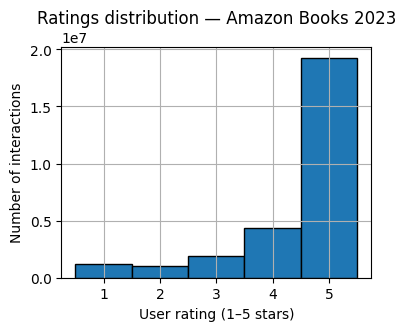

In [13]:
# ratings hist

plt.figure(figsize=(4,3))
inter_df['rating'].hist(bins=[0.5,1.5,2.5,3.5,4.5,5.5], edgecolor='black')
plt.xlabel("User rating (1–5 stars)")
plt.ylabel("Number of interactions")
plt.title("Ratings distribution — Amazon Books 2023")
plt.show()

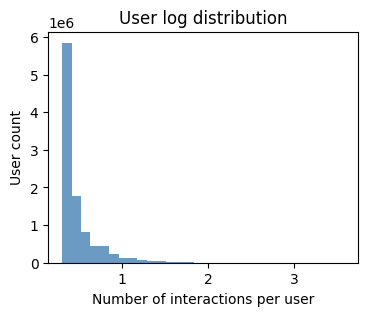

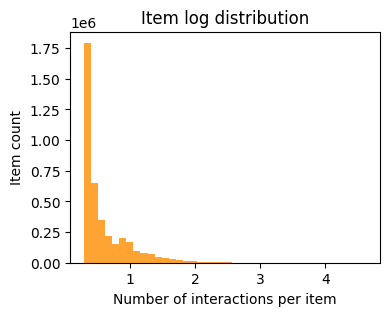

In [14]:
# User / item frequency
user_freq = inter_df['user_id'].value_counts()
item_freq = inter_df['item_id'].value_counts()

plt.figure(figsize=(4,3))
plt.hist(np.log10(user_freq + 1), bins=30, color='steelblue', alpha=0.8)
plt.xlabel("Number of interactions per user")
plt.ylabel("User count")
plt.title("User log distribution")
plt.show()

plt.figure(figsize=(4,3))
plt.hist(np.log10(item_freq + 1), bins=40, color='darkorange', alpha=0.8)
plt.xlabel("Number of interactions per item")
plt.ylabel("Item count")
plt.title("Item log distribution")
plt.show()

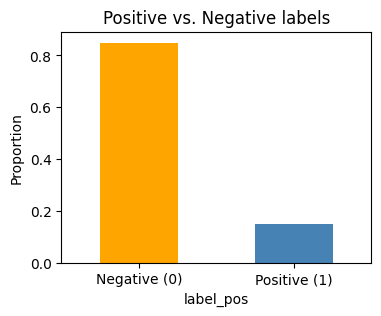

In [15]:
# Pos vs Neg labels

plt.figure(figsize=(4,3))
inter_df['label_pos'].value_counts(normalize=True).plot(kind='bar', color=['orange','steelblue'])
plt.xticks([0,1], ['Negative (0)','Positive (1)'], rotation=0)
plt.ylabel("Proportion")
plt.title("Positive vs. Negative labels")
plt.show()

In [ ]:
# Description Length: 

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
texts = items_df["description"]  # keep as a Series
N = len(texts)
lengths = np.empty(N, dtype=np.int32)

B = 2048 
for i in tqdm(range(0, N, B), desc="Tokenizing (full)"):
    batch = texts.iloc[i:i+B].tolist()
    enc = tokenizer(
        batch,
        add_special_tokens=True,
        truncation=False,
        padding=False,
        return_length=True
    )
    if "length" in enc:  # fast tokenizers return this
        lengths[i:i+len(batch)] = np.asarray(enc["length"], dtype=np.int32)
    else:
        lengths[i:i+len(batch)] = np.asarray([len(x) for x in enc["input_ids"]], dtype=np.int32)

items_df["token_len"] = lengths  # single assign at the end

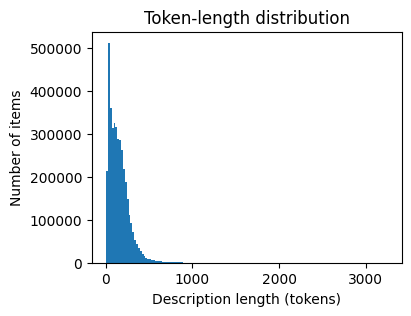

In [22]:
# 1) Tokens

# Plot
plt.figure(figsize=(4,3))
plt.hist(lengths, bins=150)
plt.xlabel("Description length (tokens)")
plt.ylabel("Number of items")
plt.title("Token-length distribution")
plt.show()

In [17]:
# Quick stats to decide truncation vs chunking
p50 = np.percentile(lengths, 50)
p90 = np.percentile(lengths, 90)
p99 = np.percentile(lengths, 99)
share_over_512 = (lengths > 512).mean()
print(f"p50={p50:.0f}, p90={p90:.0f}, p99={p99:.0f}, share>512={share_over_512:.3%}")

p50=130, p90=292, p99=547, share>512=1.263%


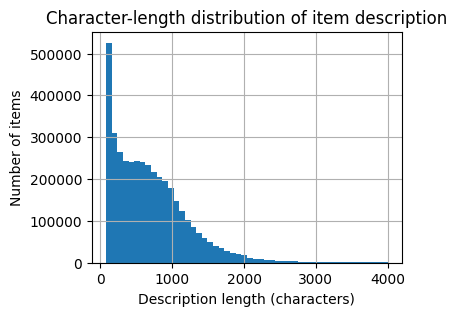

In [18]:
# 2) Characters

plt.figure(figsize=(4,3))
items_df['desc_len'].hist(bins=50)
plt.xlabel("Description length (characters)")
plt.ylabel("Number of items")
plt.title("Character-length distribution of item description")
plt.show()

In [19]:
# Summary stats
u_cnt = inter_df["user_id"].nunique()
i_cnt = inter_df["item_id"].nunique()
print("Users:", u_cnt)
print("Items:", i_cnt)
print("Interactions:", len(inter_df))
print("Positives (%):", round(inter_df['label_pos'].mean()*100, 2))
print("Average interactions per user:", len(inter_df)/inter_df['user_id'].nunique())
print("Average interactions per item:", len(inter_df)/inter_df['item_id'].nunique())

Users: 10014001
Items: 3981337
Interactions: 27830991
Positives (%): 84.98
Average interactions per user: 2.779207930975841
Average interactions per item: 6.990363036336788


### 7. Build Chronological Sequences (C-LOO) and Long-Tail Eval Split
We sort each user’s interactions by timestamp. For users with __≥3 events__, we keep the last item as the predict-next target and the preceding items as history.

#### 7.1 Diagnose LOO (Chronological Leave-One-Out) viability (how many users survive ≥3?)

Baseline (pre-LOO) — from earlier EDA
Users: 10,014,001
Items: 3,981,337
Interactions: 27,830,991
Positives (%): 84.98
Avg interactions/user: 2.779
Avg interactions/item: 6.990

Users with ≥3 interactions: 23.80%  (2,383,614 users)
User interaction quantiles: {0.5: 1.0, 0.75: 2.0, 0.9: 5.0, 0.95: 8.0, 0.99: 23.0}


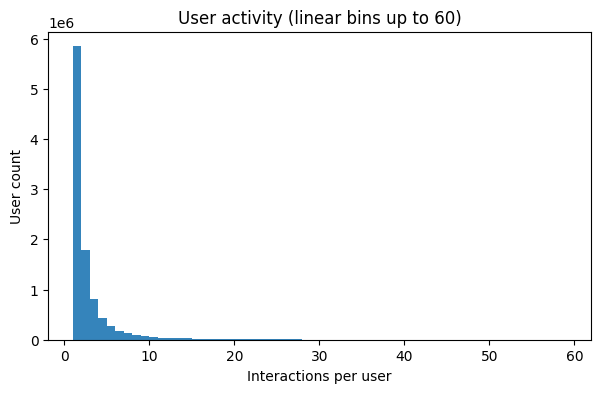

In [14]:
print("Baseline (pre-LOO) — from earlier EDA")
n_int = len(inter_df)
print(f"Users: {u_cnt:,}")
print(f"Items: {i_cnt:,}")
print(f"Interactions: {n_int:,}")
print(f"Positives (%): {inter_df['label_pos'].mean()*100:.2f}")
print(f"Avg interactions/user: {n_int/u_cnt:.3f}")
print(f"Avg interactions/item: {n_int/i_cnt:.3f}")

# Distribution of interactions per user + % with >=3
user_deg = inter_df["user_id"].value_counts()
p_ge3 = (user_deg >= 3).mean()
print(f"\nUsers with ≥3 interactions: {p_ge3*100:.2f}%  ({(user_deg>=3).sum():,} users)")

# plot
quantiles = user_deg.quantile([.5,.75,.9,.95,.99]).round(2)
print("User interaction quantiles:", quantiles.to_dict())

plt.figure(figsize=(7,4))
bins = np.arange(1, min(60, user_deg.max()+2))
plt.hist(user_deg.values, bins=bins, alpha=0.9)
plt.xlabel("Interactions per user")
plt.ylabel("User count")
plt.title("User activity (linear bins up to 60)")
plt.show()


In [11]:
# params
SEQ_DIR = Path("data/processed/books/seq")
SEQ_DIR.mkdir(parents=True, exist_ok=True)

# History shaping
MIN_HISTORY   = 2     # require at least 2 items in history (so total per user ≥ 3)
MAX_HISTORY   = 50    # cap to most recent K; set None for no cap
DEDUP_CONSEC  = True  # drop consecutive duplicates in history

# Tail definition
TAIL_FRACTION = 0.20  # bottom 20% items by frequency

# Columns to keep in outputs
SEQ_COLS = ["user_id","history","target","target_ts","hist_len"]

#### 7.2 C-LOO (Chronological leave-one-out)

In [12]:
# Sort chronologically
df = inter_df.loc[:, ["user_id","item_id","timestamp"]].sort_values(
    ["user_id","timestamp"], kind="stable"
).reset_index(drop=True)

# Keep only users with ≥ (MIN_HISTORY + 1) total events
user_deg = df["user_id"].value_counts()
eligible_users = user_deg.index[user_deg >= (MIN_HISTORY + 1)]
df_elig = df[df["user_id"].isin(eligible_users)].copy()

print(f"Eligible users (≥{MIN_HISTORY+1} interactions): {len(eligible_users):,} "
      f"({len(eligible_users)/user_deg.size*100:.2f}% of users)")
print(f"Interactions retained for C-LOO pipeline: {len(df_elig):,} "
      f"({len(df_elig)/len(df)*100:.2f}% of interactions)")

# Group into sequences
g = df_elig.groupby("user_id", sort=False)

Eligible users (≥3 interactions): 2,383,614 (23.80% of users)
Interactions retained for C-LOO pipeline: 18,415,869 (66.17% of interactions)


In [13]:
rows = []
for uid, grp in g:
    items = grp["item_id"].tolist()
    times = grp["timestamp"].tolist()

    # last is target
    target, target_ts = items[-1], int(times[-1])

    # history = all but last
    history = items[:-1]
    history = shape_history(history, dedup_consec=DEDUP_CONSEC, max_history=MAX_HISTORY)
    if len(history) < MIN_HISTORY:
        continue

    rows.append((uid, history, target, target_ts, len(history)))

c_loo_df = pd.DataFrame(rows, columns=SEQ_COLS)
print(f"C-LOO sequences: {len(c_loo_df):,} rows | mean hist_len={c_loo_df['hist_len'].mean():.2f}")

# Save
c_loo_fp = SEQ_DIR / "c_loo_sequences.parquet"
c_loo_df.to_parquet(c_loo_fp, index=False)
print("Saved ", c_loo_fp)

C-LOO sequences: 2,383,614 rows | mean hist_len=5.97
Saved  data/processed/books/seq/c_loo_sequences.parquet


In [24]:
c_loo_df.head(3)

,user_id,history,target,target_ts,hist_len
0,AE22236AFRRSMQIKGG7TPTB75QEA,"[0441008534, 0441009239, 0375826688, B002KQ6BT...",0061058386,933306819000,13
1,AE2224D3S4GTKVFJ5V7ZRQJ7P4FQ,"[1476754454, B003KK5RR8, B002U3CBLQ, B01N5XZCTV]",038575311X,1563064820,4
2,AE2224IMTLGXRXJITJJOW5RSMW5Q,"[1602397724, 006170301X, 1402775075]",0316227706,1356701157,3


In [32]:
# Summary stats for hist_len
s = c_loo_df["hist_len"]
print("Rows:", len(s))
print("Min/Max:", int(s.min()), "/", int(s.max()))
print("Mean/Median:", round(s.mean(), 3), "/", int(s.median()))
print("Std:", round(s.std(), 3))

qs = [0.5, 0.75, 0.9, 0.95, 0.99]
pct = s.quantile(qs).astype(int)
print("\nQuantiles:")
for q, v in zip(qs, pct):
    print(f"  q={q:>4.2f} → {v}")
print()
# Share of short histories (handy sanity checks)
for k in [2,3,5,10,20]:
    share = (s <= k).mean() * 100
    print(f"  ≤{k}: {share:5.2f}%")

Rows: 2383614
Min/Max: 2 / 50
Mean/Median: 5.968 / 3
Std: 7.61

Quantiles:
  q=0.50 → 3
  q=0.75 → 6
  q=0.90 → 12
  q=0.95 → 19
  q=0.99 → 50

  ≤2: 33.91%
  ≤3: 52.47%
  ≤5: 71.50%
  ≤10: 87.84%
  ≤20: 95.47%


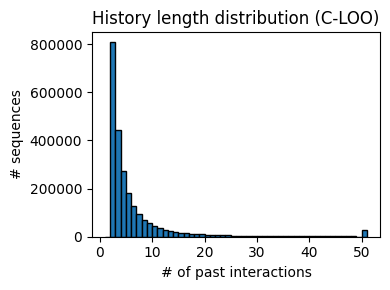

In [31]:
hist = c_loo_df["hist_len"].to_numpy()
bins = np.arange(1, hist.max() + 2)  # 1-bin per length

plt.figure(figsize=(4,3))
plt.hist(hist, bins=bins, edgecolor="black")
plt.title("History length distribution (C-LOO)")
plt.xlabel("# of past interactions")
plt.ylabel("# sequences")
plt.tight_layout()
plt.show()


#### 7.3 Tail-Target LOO (targets in the tail only)

In [18]:
# Item frequencies among retained interactions
item_freq = df_elig["item_id"].value_counts()
cutoff = item_freq.quantile(TAIL_FRACTION)
tail_items = set(item_freq[item_freq <= cutoff].index)

print(f"Tail cutoff (bottom {TAIL_FRACTION:.0%}): freq ≤ {int(cutoff)} "
      f"| tail items = {len(tail_items):,}")

tail_df = c_loo_df[c_loo_df["target"].isin(tail_items)].reset_index(drop=True)
print(f"Tail-Target LOO sequences: {len(tail_df):,} "
      f"({len(tail_df)/len(c_loo_df)*100:.2f}% of C-LOO)")

tail_fp = SEQ_DIR / "tail_target_loo.parquet"
tail_df.to_parquet(tail_fp, index=False)
print("Saved ", tail_fp)

Tail cutoff (bottom 20%): freq ≤ 1 | tail items = 1,553,295
Tail-Target LOO sequences: 239,519 (10.05% of C-LOO)
Saved  data/processed/books/seq/tail_target_loo.parquet


In [19]:
tail_df.head(3)

,user_id,history,target,target_ts,hist_len
0,AE2247UG4CWYBQSHP45IFUP4I4NA,"[0785833870, 159186559X]",B089TV17J6,1630247174,2
1,AE225HZNREJ3VMBD34OY7FROMVFA,"[0985260009, 0310729939]",1514238942,1451942784,2
2,AE225OD5SZXPS5MLN4AXQCMJH6OA,"[0312274920, 1786811294, 1620408910, 1090879865]",B094ZN6FC7,1665012082,4


#### 7.4 Sanity checks

In [20]:
show_examples(c_loo_df, 3)
show_examples(tail_df, 3)

Examples (k=3):
- user=AE22236AFRRSMQIKGG7TPTB75QEA | hist_len=13 | history[:5]=['0441008534', '0441009239', '0375826688', 'B002KQ6BT6', '0765362643']... | target=0061058386
- user=AE2224D3S4GTKVFJ5V7ZRQJ7P4FQ | hist_len=4 | history[:5]=['1476754454', 'B003KK5RR8', 'B002U3CBLQ', 'B01N5XZCTV']... | target=038575311X
- user=AE2224IMTLGXRXJITJJOW5RSMW5Q | hist_len=3 | history[:5]=['1602397724', '006170301X', '1402775075']... | target=0316227706
Examples (k=3):
- user=AE2247UG4CWYBQSHP45IFUP4I4NA | hist_len=2 | history[:5]=['0785833870', '159186559X']... | target=B089TV17J6
- user=AE225HZNREJ3VMBD34OY7FROMVFA | hist_len=2 | history[:5]=['0985260009', '0310729939']... | target=1514238942
- user=AE225OD5SZXPS5MLN4AXQCMJH6OA | hist_len=4 | history[:5]=['0312274920', '1786811294', '1620408910', '1090879865']... | target=B094ZN6FC7


In [22]:
c_fp = SEQ_DIR / "c_loo_sequences.parquet"
# Load just the target column
c_loo = pd.read_parquet(c_fp, columns=["target"])
# Approximation: target frequency inside C-LOO (sufficient for tail analysis)
target_freq = c_loo["target"].value_counts()
tail_table = eval_tail(c_loo=c_loo, target_freq=target_freq)
display(tail_table.sort_values("tail_fraction"))

,tail_fraction,freq_cutoff,tail_sequences,share_of_eval_%
0,0.10,1,650081,27.272914
1,0.15,1,650081,27.272914
2,0.20,1,650081,27.272914
3,0.25,1,650081,27.272914
4,0.30,1,650081,27.272914


### 8. Save the data

In [8]:
items_df.to_parquet(ITEMS_OUT, index=False)
inter_df.to_parquet(INTER_OUT, index=False)